# Recommendation System -- Top 10 Products for Amazon

## Context

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what’s most likely to keep them engaged and help business. 

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalised recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analysing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.


## Objective
You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labelled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.


## Data Dictionary
The Amazon dataset contains the following attributes:

- userId: Every user identified with a unique id
- productId: Every product identified with a unique id
- Rating: The rating of the corresponding product by the corresponding user
- timestamp: Time of the rating. We will not use this column to solve the current problem

# Data Loading

In [1]:
# install libraries

%pip install scikit-surprise
%pip install torch

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# base libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# ml
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

# error handling
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

In [3]:
# import data
data = pd.read_csv("/Users/lukeroberts/My Drive(lukejrobertsza@gmail.com)/Colab Notebooks/mit_adsp_notebooks/7.1.elective_project/ratings_Electronics.csv")

In [4]:
# copy the data
copy_of_data = data.copy()

In [5]:
data.shape

(7824481, 4)

In [6]:
data

,AKM1MP6P0OYPR,0132793040,5.0,1365811200
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600
...,...,...,...,...
7824476,A2YZI3C9MOHC0L,BT008UKTMW,5.0,1396569600
7824477,A322MDK0M89RHN,BT008UKTMW,5.0,1313366400
7824478,A1MH90R0ADMIK0,BT008UKTMW,4.0,1404172800
7824479,A10M2KEFPEQDHN,BT008UKTMW,4.0,1297555200


In [70]:
# Assign column headers without replacing the first row
data.columns = ['user', 'item', 'rating', 'timestamp']
copy_of_data.columns = ['user', 'item', 'rating', 'timestamp']

In [8]:
data.shape

(7824481, 4)

In [9]:
# check the first row has not been replace
data[data['user'] == 'AKM1MP6P0OYPR']

,user,item,rating,timestamp
5200190,AKM1MP6P0OYPR,B005UEB5TQ,5.0,1366243200


Observations

- the dataset has 7,824,484 rows and 4 columns
- the columns have headings, and have been renamed according to the descriptions given
- - 'user', 'item', 'rating', 'timestamp'



In [10]:
# loop through data and return unique values

for col in data.columns:
	unique_vals = data[col].unique()
	print(f"{col}: unique values = {len(unique_vals)} ({round(len(unique_vals) / data.shape[0], 2)})")

print(f"total rows: {data.shape[0]}")


user: unique values = 4201696 (0.54)
item: unique values = 476001 (0.06)
rating: unique values = 5 (0.0)
timestamp: unique values = 5489 (0.0)
total rows: 7824481


Observations
- 54% of users are unique, meaning on average each user rated roughly twice
- most items are unique

In [27]:
# inspect dataset size
data_size_gb = data.memory_usage(deep=True).sum() / (1024 ** 3)
print(f"Data size: {data_size_gb:.2f} GB")
data_size_mb = data.memory_usage(deep=True).sum() / (1024 ** 2)
print(f"Data size: {data_size_mb:.2f} MB")

Data size: 1.00 GB
Data size: 1027.83 MB


Observations
- the dataset is 1GB once imported
- this is computationally expensive to build a model off the entire data set right now
- consider reducing the dataset to build and explore
- - possibly train final model on full dataset

## Data Cleaning & Preperation

In [34]:
# create a column of only users
users = data.user

# creat an empty dictionary to store ratings count
ratings_count = dict()

# loop through users column
for user in users:
    # if the user is already in the ratings_count dict, add + 1
    if user in ratings_count:        
        ratings_count[user] += 1
    # otherwise just add 1
    else:
        ratings_count[user] = 1 

In [ ]:
# length on new ratings_count dictionary
len(ratings_count)

4201696

In [ ]:
# sum up the ratings per user
sum(ratings_count.values())


7824481

Observations
- the length of the ratings_count dictionary is equal to the length of the unique values of users
- this makes sense as each user will have at least one rating
- the total of the dictionary values, i.e. the sum of all ratings is equal to the length of data
- this step helps us understand user engagement and will be useful for filtering users with very few ratings
- 'ratings_count' is a dictionary of the quantity of ratings by each user

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824481 entries, 0 to 7824480
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   user       object 
 1   item       object 
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [23]:
users.shape

(7824481,)

- After creating a dictionary of all users and the number of ratings they have done.
- We can set a threshold on how many ratings we want a user to have done, before being considered

In [79]:
# lets view ratings by user to determine where to set the threshold

data_grouped_user_ratings = data.groupby('user')['rating'].count().sort_values(ascending=False)

In [83]:
data_grouped_user_ratings

user
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
                 ... 
A2HRB8UOXH92SQ      1
A2HRBA4HO2E4GU      1
A2HRBCM00IDK56      1
A2HRBEBDTIB8MT      1
AZZZY1W55XHZR       1
Name: rating, Length: 4201696, dtype: int64

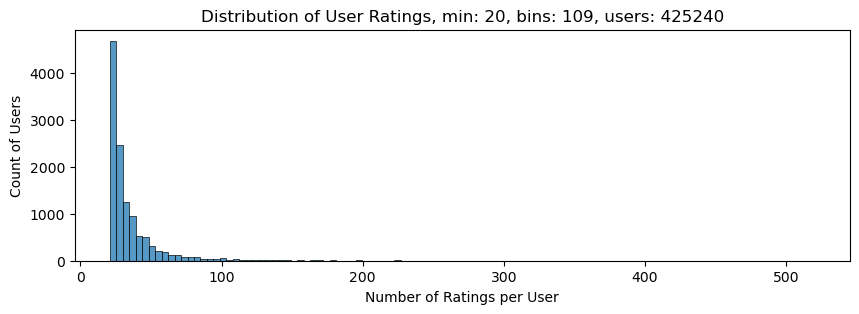

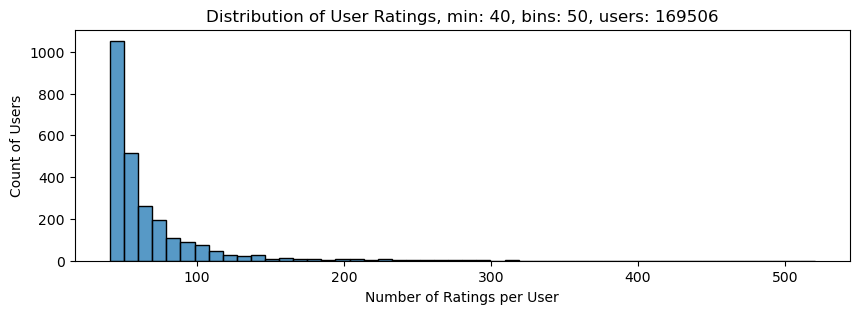

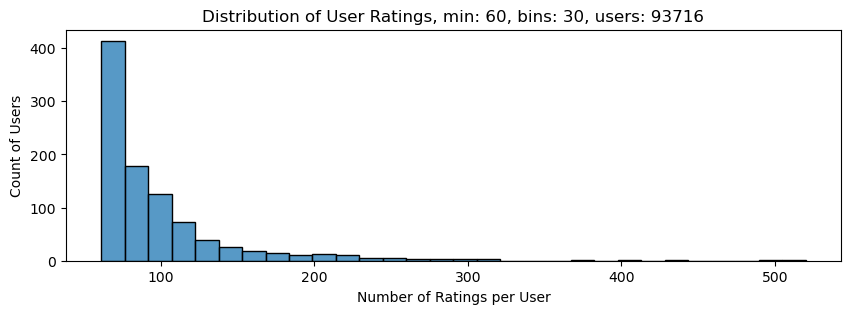

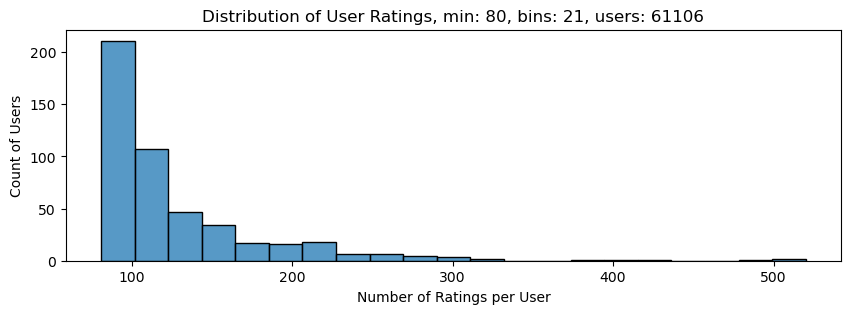

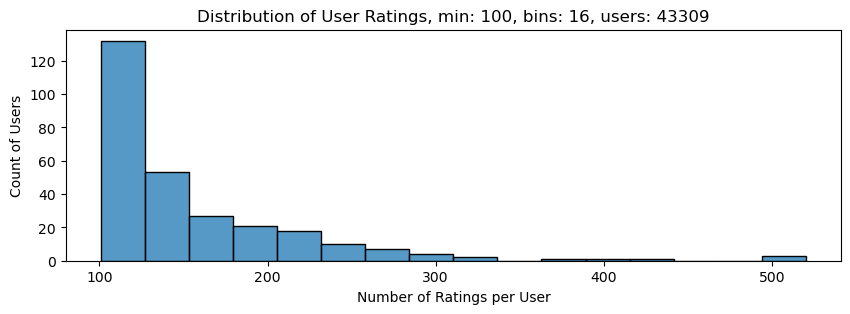

In [100]:
# plot range of thresholds

for threshold in range(20, 120, 20):
    plot_threshold = threshold
    filtered_data = data_grouped_user_ratings[data_grouped_user_ratings > plot_threshold]
    optimal_bins = int(np.sqrt(len(filtered_data)))

    plt.figure(figsize=(10,3))
    sns.histplot(data=filtered_data, bins=optimal_bins)

    plt.xlabel('Number of Ratings per User')
    plt.ylabel('Count of Users')
    plt.title(f'Distribution of User Ratings, min: {threshold}, bins: {optimal_bins}, users: {data_grouped_user_ratings[data_grouped_user_ratings > plot_threshold].sum()}')
    plt.show()

In [103]:
# Common thresholds for recommendation systems
candidate_thresholds = [5, 10, 20, 30, 50, 100]

def analyze_threshold_impact(threshold):
    filtered_users = ratings_per_user[ratings_per_user >= threshold].index
    filtered_data = data[data.user.isin(filtered_users)]
    
    # Calculate sparsity
    n_users = len(filtered_users)
    n_items = filtered_data['item'].nunique()
    n_ratings = len(filtered_data)
    sparsity = 1 - (n_ratings / (n_users * n_items))
    
    return {
        'threshold': threshold,
        'users': n_users,
        'items': n_items,
        'ratings': n_ratings,
        'sparsity': sparsity,
        'users_pct': n_users / len(ratings_per_user) * 100,
        'data_pct': n_ratings / len(data) * 100
    }

# Analyze each threshold
print("Threshold Analysis:")
print("Threshold | Users | Items | Ratings | Sparsity | Users% | Data%")
print("-" * 70)

for threshold in candidate_thresholds:
    stats = analyze_threshold_impact(threshold)
    print(f"{stats['threshold']:>8} | {stats['users']:>5} | {stats['items']:>5} | "
          f"{stats['ratings']:>7} | {stats['sparsity']:>6.3f} | "
          f"{stats['users_pct']:>5.1f}% | {stats['data_pct']:>4.1f}%")

Threshold Analysis:
Threshold | Users | Items | Ratings | Sparsity | Users% | Data%
----------------------------------------------------------------------
       5 | 254064 | 284800 | 2281128 |  1.000 |   6.0% | 29.2%
      10 | 63175 | 193120 | 1089763 |  1.000 |   1.5% | 13.9%
      20 | 13351 | 115394 |  452040 |  1.000 |   0.3% |  5.8%
      30 |  5276 | 81228 |  262917 |  0.999 |   0.1% |  3.4%
      50 |  1540 | 48190 |  125871 |  0.998 |   0.0% |  1.6%
     100 |   289 | 22635 |   44209 |  0.993 |   0.0% |  0.6%


In [ ]:
# Step 1: Quick analysis
def recommend_threshold(data):
    ratings_per_user = data.groupby('user')['rating'].count()
    
    # Rule 1: Ensure sufficient data
    median_ratings = ratings_per_user.median()
    
    # Rule 2: Keep reasonable number of users (aim for 10-30% of users)
    percentile_75 = np.percentile(ratings_per_user, 75)
    
    # Rule 3: Consider computational constraints
    if len(data) > 5_000_000:  # Large dataset
        suggested_threshold = max(20, percentile_75)
    else:
        suggested_threshold = max(10, median_ratings)
    
    return int(suggested_threshold)

suggested_threshold = recommend_threshold(data)
print(f"Suggested threshold: {suggested_threshold}")

Suggested threshold: 20


In [ ]:
# setting thresholds to find users that we can trust
THRESHOLD_USERS = 20

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < THRESHOLD_USERS:
        remove_users.append(user)

# create a new df with users that are not in (left over) from remove_users list
data_cleaned = data.loc[~ data.user.isin(remove_users)]

In [106]:
data_cleaned.shape[0] / data.shape[0]

0.057772521909120876

Observations
- after exploring the distribution of the data, 20 ratings per user is considered the minimum required
- only 6% of the data remains, when dropping all users who have rated below the threshold

In [134]:
data_cleaned.shape

(452040, 4)

In [108]:
# create a column of only items
items = data.item

# creat an empty dictionary to store ratings count
ratings_count = dict()

# loop through users column
for item in items:
    # if the item is already in the ratings_count dict, add + 1
    if item in ratings_count:        
        ratings_count[item] += 1
    # otherwise just add 1
    else:
        ratings_count[item] = 1 

In [109]:
# length on new ratings_count dictionary
len(ratings_count)


476001

In [110]:

# sum up the ratings per user
sum(ratings_count.values())


7824481

Observations
- there are 476001 items with ratings
- this is equal to the number of unique items
- when summing the number of ratings per item, it is equal to the total number of observations of the data

In [ ]:
# lets view ratings per item to determine where to set the threshold
data_grouped_item_ratings = data.groupby('item')['rating'].count().sort_values(ascending=False)


In [115]:
data_grouped_item_ratings

item
B0074BW614    18244
B00DR0PDNE    16454
B007WTAJTO    14172
B0019EHU8G    12285
B006GWO5WK    12226
              ...  
B004WL91KI        1
B004WL9FK4        1
B004WL9Q2Q        1
B004WL9R8O        1
BT008V9J9U        1
Name: rating, Length: 476001, dtype: int64

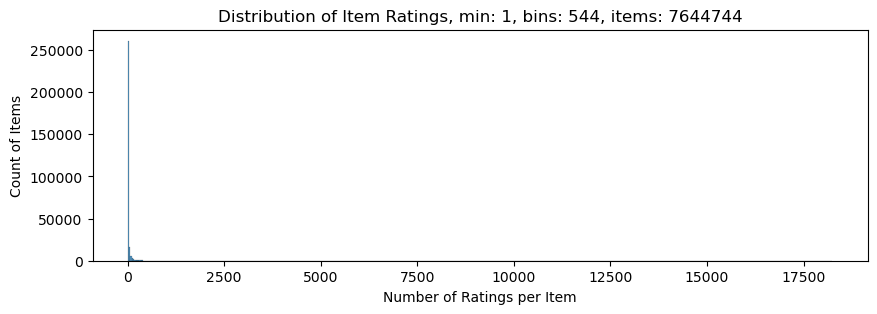

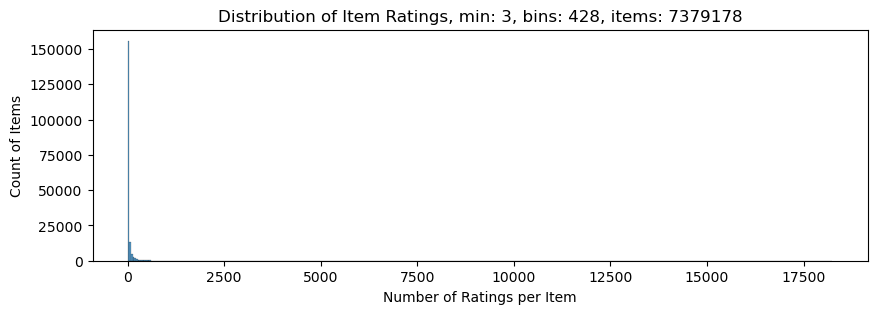

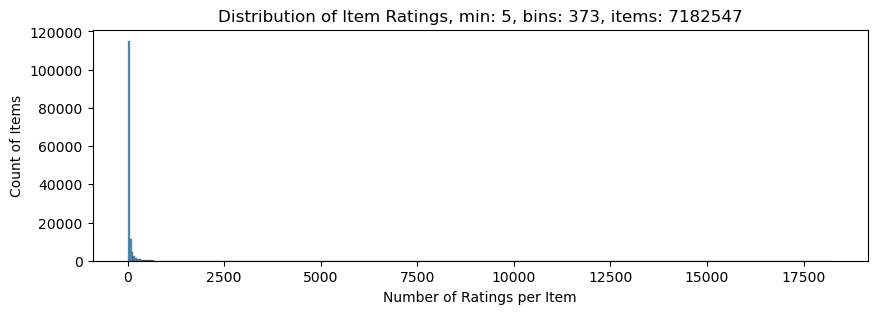

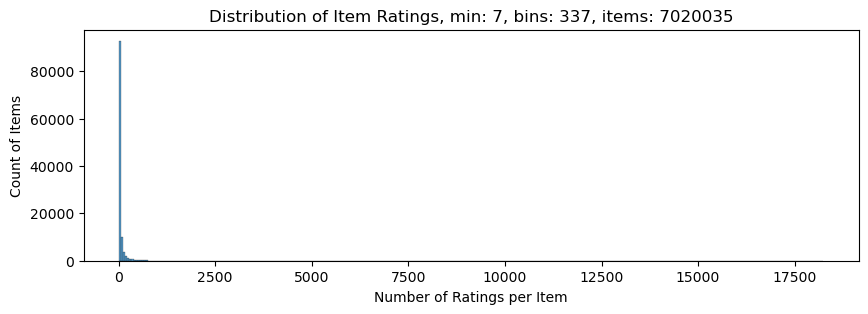

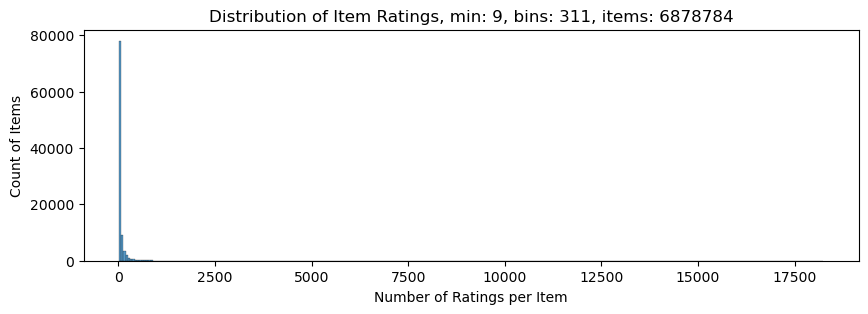

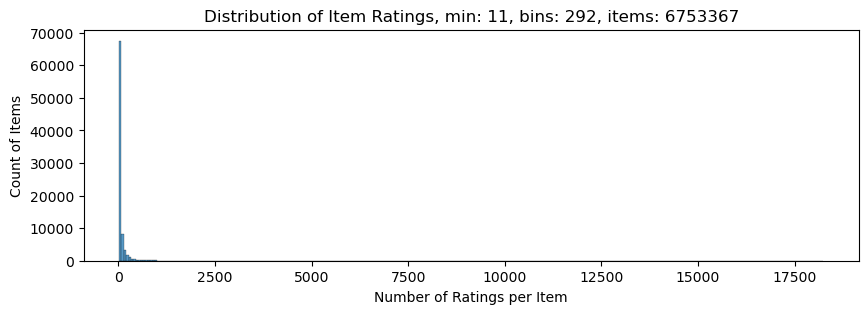

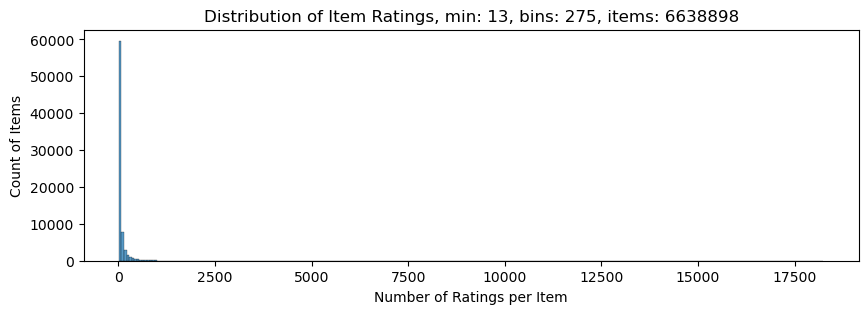

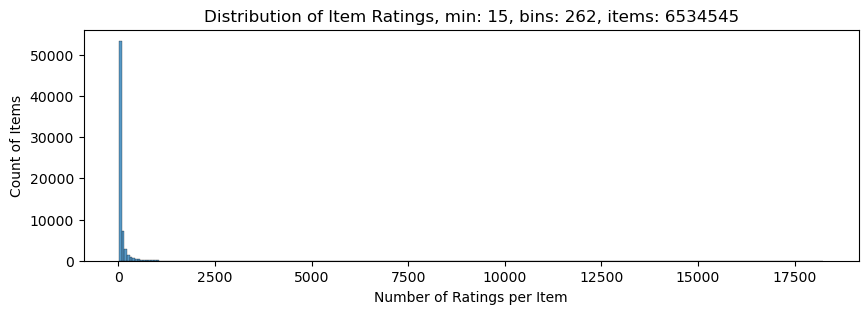

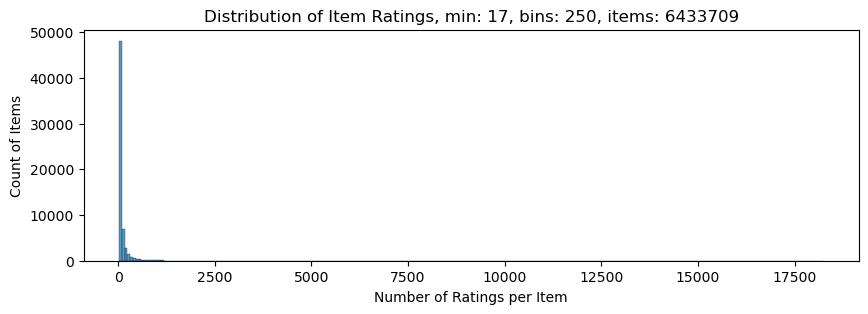

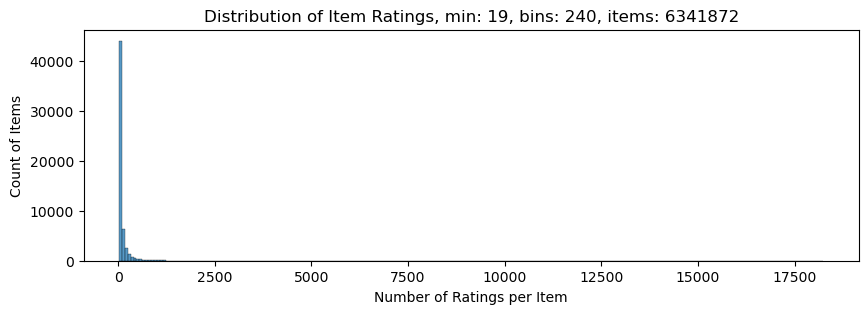

In [124]:
# plot range of thresholds

for threshold in range(1, 20, 2):
    plot_threshold = threshold
    filtered_data = data_grouped_item_ratings[data_grouped_item_ratings > plot_threshold]
    optimal_bins = int(np.sqrt(len(filtered_data)))

    plt.figure(figsize=(10,3))
    sns.histplot(data=filtered_data, bins=optimal_bins)

    plt.xlabel('Number of Ratings per Item')
    plt.ylabel('Count of Items')
    plt.title(f'Distribution of Item Ratings, min: {threshold}, bins: {optimal_bins}, items: {filtered_data.sum()}')
    plt.show()

In [131]:
# Common thresholds for recommendation systems
candidate_thresholds = range(1,31,3)

def analyze_threshold_impact(threshold):
    filtered_items = data_grouped_item_ratings[data_grouped_item_ratings >= threshold].index
    filtered_data = data[data.item.isin(filtered_items)]
    
    # Calculate sparsity
    n_items = len(filtered_items)
    n_users = filtered_data['user'].nunique()
    n_ratings = len(filtered_data)
    sparsity = 1 - (n_ratings / (n_users * n_items))
    
    return {
        'threshold': threshold,
        'items': n_items,
        'users': n_users,
        'ratings': n_ratings,
        'sparsity': sparsity,
        'items_pct': n_items / len(data_grouped_item_ratings) * 100,
        'data_pct': n_ratings / len(data) * 100
    }

print("Threshold Analysis:")
print("Threshold | Items | Users | Ratings | Sparsity | Items% | Data%")
print("-" * 70)

for threshold in candidate_thresholds:
    stats = analyze_threshold_impact(threshold)
    print(f"{stats['threshold']:>8} | {stats['items']:>5} | {stats['users']:>5} | "
          f"{stats['ratings']:>7} | {stats['sparsity']:>6.3f} | "
          f"{stats['items_pct']:>6.2f}% | {stats['data_pct']:>5.2f}%")

# Explanation:
# The sparsity calculation is: 1 - (n_ratings / (n_users * n_items))
# If n_ratings is much smaller than (n_users * n_items), sparsity will be very close to 1.
# This is expected in recommendation datasets, which are extremely sparse (most users rate very few items).
# If you want to check if it's working, try printing n_ratings, n_users, n_items for a threshold,
# and manually compute: n_ratings / (n_users * n_items)
# For example, if n_ratings = 1000, n_users = 100, n_items = 1000, then
# n_users * n_items = 100,000, so 1000/100000 = 0.01, sparsity = 0.99.
# In your dataset, the number of possible user-item pairs is huge, so sparsity near 1 is correct.

Threshold Analysis:
Threshold | Items | Users | Ratings | Sparsity | Items% | Data%
----------------------------------------------------------------------
       1 | 476001 | 4201696 | 7824481 |  1.000 | 100.00% | 100.00%
       4 | 183682 | 4051227 | 7379178 |  1.000 |  38.59% | 94.31%
       7 | 125085 | 3939784 | 7098001 |  1.000 |  26.28% | 90.72%
      10 | 97249 | 3851668 | 6878784 |  1.000 |  20.43% | 87.91%
      13 | 80451 | 3777535 | 6695539 |  1.000 |  16.90% | 85.57%
      16 | 68881 | 3711982 | 6534545 |  1.000 |  14.47% | 83.51%
      19 | 60186 | 3651743 | 6387377 |  1.000 |  12.64% | 81.63%
      22 | 53487 | 3597315 | 6253715 |  1.000 |  11.24% | 79.92%
      25 | 48174 | 3546906 | 6131747 |  1.000 |  10.12% | 78.37%
      28 | 43693 | 3498776 | 6015478 |  1.000 |   9.18% | 76.88%


In [132]:
# Step 1: Quick analysis
def recommend_threshold(data):
    ratings_per_item = data.groupby('item')['rating'].count()
    
    # Rule 1: Ensure sufficient data
    median_ratings = ratings_per_item.median()
    
    # Rule 2: Keep reasonable number of items (aim for 10-30% of items)
    percentile_75 = np.percentile(ratings_per_item, 75)
    
    # Rule 3: Consider computational constraints
    if len(data) > 5_000_000:  # Large dataset
        suggested_threshold = max(20, percentile_75)
    else:
        suggested_threshold = max(10, median_ratings)
    
    return int(suggested_threshold)

suggested_threshold = recommend_threshold(data)
print(f"Suggested threshold: {suggested_threshold}")

Suggested threshold: 20


Observations
- after exploring the data, thresholds are predicted to be higehr than industry standard
- this may cause us to loose some data to training the model
- lets set teh threshold lower for training, including as much data as we can
- we will then raise teh item threshold for final model

In [136]:
# set thresholds for quantity of ratings per item

THRESHOLD_ITEMS = 5

remove_items = []

for item, num_ratings in ratings_count.items():
    if num_ratings < THRESHOLD_ITEMS:
        remove_items.append(item)

In [137]:
# create a new df with users that are not in (left over) from remove_users list
data_cleaned_2 = data_cleaned.loc[~ data_cleaned.item.isin(remove_items)]

In [138]:
data_cleaned_2.shape

(418562, 4)

In [140]:
# Calculate sparsity of the dataframe 'data'
num_users = data['user'].nunique()
num_items = data['item'].nunique()
num_ratings = len(data)
sparsity = 1 - (num_ratings / (num_users * num_items))
print(f"Sparsity of 'data': {sparsity:.4f}")

Sparsity of 'data': 1.0000


In [142]:
# Calculate sparsity of the dataframe 'data'
num_users = data_cleaned_2['user'].nunique()
num_items = data_cleaned_2['item'].nunique()
num_ratings = len(data_cleaned_2)
sparsity = 1 - (num_ratings / (num_users * num_items))
print(f"Sparsity of 'data_cleaned_2': {sparsity:.4f}")

Sparsity of 'data_cleaned_2': 0.9996


# Feature Engineering

# Model Building